# Team D Data For Housing Project: Exploration Housing Quality in Oakland

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

#mapping libraries
import matplotlib.pyplot as plt
import seaborn as sns
import geoplot as gplt
# see https://github.com/conda-forge/geoplot-feedstock for how to install geoplot
%matplotlib inline

# Importing and Readying the Housing Habitability Data:

Tasks:
- read in csv which includes address, a simplified address (Address_recode doesn't include unit numbers, number of complaints, lat, long)
- drop all the extra columns
- set the lat and long as geometry
- read invCA census tracts
- spatially join the census tracts with the hh complaints so that each record has a census tract associated
- drop all uneccessary columns

In [2]:
#read in housing habitability data, EACH TEAM MEMBER WILL HAVE DIFFERENT PATH
#is there a way to do this directly from the google drive?
hh = pd.read_csv(r'C:\Users\amarq\Python_Projects\raw_data\Oakland Housing Habitability Complaints_2014to2018_geocoded.csv')
#I'm realizing that I made a terrible mistake saving this as a csv and not a geojson, so, instead, I'm redoing the sjoin here

In [3]:
hh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   STATEFP         2776 non-null   int64  
 1   COUNTYFP        2776 non-null   int64  
 2   TRACTCE         2776 non-null   int64  
 3   AFFGEOID        2776 non-null   object 
 4   GEOID           2776 non-null   int64  
 5   NAME            2776 non-null   float64
 6   LSAD            2776 non-null   object 
 7   ALAND           2776 non-null   int64  
 8   AWATER          2776 non-null   int64  
 9   geometry        2776 non-null   object 
 10  index_right     2776 non-null   int64  
 11  Address         2776 non-null   object 
 12  Year            2776 non-null   int64  
 13  HH_Complaint    2776 non-null   int64  
 14  Address_recode  2776 non-null   object 
 15  latitude        2776 non-null   float64
 16  longitude       2776 non-null   float64
dtypes: float64(3), int64(9), object(5

In [4]:
#dropping the original census tract
columns_to_drop = ['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER', 'geometry', \
                  'index_right', 'Year']
hh.drop(columns=columns_to_drop, inplace=True)

In [5]:
hh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Address         2776 non-null   object 
 1   HH_Complaint    2776 non-null   int64  
 2   Address_recode  2776 non-null   object 
 3   latitude        2776 non-null   float64
 4   longitude       2776 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 108.6+ KB


In [6]:
#setting the lat and lon as geometry and turning it into a geodataframe
hh_gdf = gpd.GeoDataFrame(hh, geometry=gpd.points_from_xy(hh.longitude, hh.latitude))

In [7]:
hh_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Address         2776 non-null   object  
 1   HH_Complaint    2776 non-null   int64   
 2   Address_recode  2776 non-null   object  
 3   latitude        2776 non-null   float64 
 4   longitude       2776 non-null   float64 
 5   geometry        2776 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 130.2+ KB


In [8]:
# read in function created by the D4H team to grab census tracts
# Census FTP Site
BASE_GEO = "https://www2.census.gov/geo/tiger/"
California_Tracts_GDF = rf'C:\Users\amarq\Python_Projects\out_data\calitracts.json'

def fetch_tract_geodata(BASE, year, state, out_file_name):
    '''
    The function below fetches Census cartographic boundary files from the Census FTP site. 
    The function reads the zipped geodata from the FTP url and saves it in memory as a pandas 
    geodataframe. Then it saves the geodata to a geojson file.
    
    Parameters:
        BASE (str): base url for the data
        year (int): the year of data
        state (str): 2-digit state FIPS code
        out_file_name (str): file name for the output geojson
        
    Returns:
    
        gdf: a geodataframe of Census tract boundaries
    
    '''
    # Start function
    print("...fetching Census tract boundaries")
    
    # Build enhanced base url
    param_geo = "GENZ"+str(year)+ "/shp/cb_"+str(year)+"_"+state+"_tract_500k.zip"
    
    # Read in tracts geodata
    tracts = gpd.read_file(BASE+param_geo)
    
    # Save tract boundaries to file as a geojson
    print(f"...saving tract boundaries to file: {out_file_name}")
    tracts.to_file(driver='GeoJSON', filename=out_file_name)
    print("saved")
    
    # Return geodataframe
    return tracts

In [9]:
#run function to get CA census tracts
tracts_gdf = fetch_tract_geodata(BASE_GEO,2018,'06',California_Tracts_GDF)

...fetching Census tract boundaries
...saving tract boundaries to file: C:\Users\amarq\Python_Projects\out_data\calitracts.json
saved


In [10]:
#spatial join between CA census tracts and the hh_gdf
#first check they are in same CRS
print(tracts_gdf.crs)
print(hh_gdf.crs)

epsg:4269
None


In [11]:
#set the hh_gdf.crs to tracts_gdf
hh_gdf.set_crs(tracts_gdf.crs, inplace=True)
# double check they are the same
hh_gdf.crs == tracts_gdf.crs

True

In [12]:
#now do the spatial join
gdf = gpd.sjoin(tracts_gdf,hh_gdf)

In [13]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2776 entries, 78 to 7853
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   STATEFP         2776 non-null   object  
 1   COUNTYFP        2776 non-null   object  
 2   TRACTCE         2776 non-null   object  
 3   AFFGEOID        2776 non-null   object  
 4   GEOID           2776 non-null   object  
 5   NAME            2776 non-null   object  
 6   LSAD            2776 non-null   object  
 7   ALAND           2776 non-null   int64   
 8   AWATER          2776 non-null   int64   
 9   geometry        2776 non-null   geometry
 10  index_right     2776 non-null   int64   
 11  Address         2776 non-null   object  
 12  HH_Complaint    2776 non-null   int64   
 13  Address_recode  2776 non-null   object  
 14  latitude        2776 non-null   float64 
 15  longitude       2776 non-null   float64 
dtypes: float64(2), geometry(1), int64(4), object(9)
mem

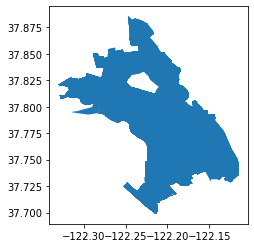

In [14]:
#double check it looks about right as Oakland.
gdf.plot()

In [15]:
#save as geojason
gdf.to_file("OalandHousingHabitabilityComplaints2013to2018Geocoded.geojson", driver='GeoJSON')

# Exploration of Healthy Housing Complaint Data

(From Presentation)

**Descriptive Analysis:** 
- where do complaints typically come from? 
- Most common building type (by # of units in building) or building age
- How many complaints per census tract?

**Output:**
- Dot map: complaints in Oakland (using addresses/parcels)
- Choropleth: Aggregated complaints at tract or block group level 
- Bar Charts: # Complaints per building characteristic (size of parcel, number of units, building age)
- Maps: distribution of each major ‘building type’ (SFH, 2-4 units, 5-15 units, 15+ units) 

**Method**

1) Dot Map

    a) Read in Oakland Boundary for Mapping
    b) Run code for Dot Map
    c) Save Dot Map to out_maps folder
    
2) Heat Hap

    a) Run code for Heat Map (geoplot)
    b) Save Heat Map to out_maps folder
    
3) Choropleth Map

    a) Create data frame of census tracts, their geometry, and the sum of addresses with complaints in that tract
    b) Run code for basic Choropleth Map
    c) Save Chloropleth Map to out_maps folder
    
    
    

In [16]:
# 1a) bring in Oakland Boundary for Mapping
oakland_bounds = gpd.read_file(rf'C:\Users\amarq\Python_Projects\raw_data\City of Oakland City Limits.geojson')

In [17]:
#set the oakland_bounds CRS to match the rest of them
oakland_bounds.to_crs(tracts_gdf.crs, inplace=True)
oakland_bounds.crs == tracts_gdf.crs

True

In [18]:
#clip CA tracts into Oakland
tracts_oakland_clipped = gpd.clip(tracts_gdf, oakland_bounds).reset_index(drop=True)


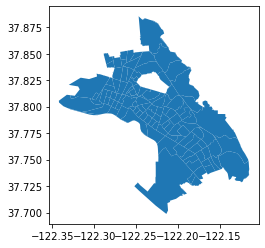

In [19]:
#map tracs_oakland to confirm
tracts_oakland_clipped.plot()

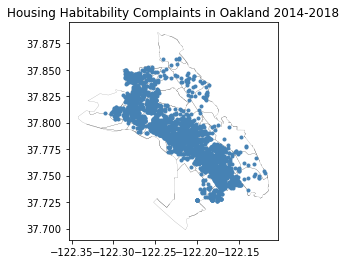

In [20]:
#create dot map with census tracts as outlines
# we use hh_gdf for the points and tracts_oakland_clipped for the background

fig, ax = plt.subplots()

tracts_oakland_clipped.plot(ax=ax,
                            color='None',
                            edgecolor='black',
                           linewidth=.1)

hh_gdf.plot(ax=ax, #hh_gdf is the dataframe with the point data
           marker = '.',
           color = 'steelblue')

plt.title('Housing Habitability Complaints in Oakland 2014-2018')
plt.show()

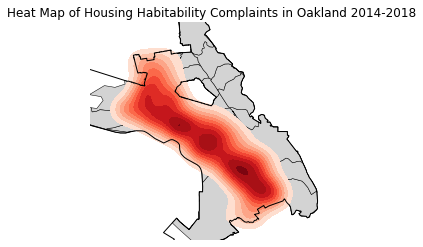

In [21]:
# Heat Map Per https://residentmario.github.io/geoplot/plot_references/plot_reference.html#kdeplot

fig, ax = plt.subplots()

tracts_oakland_clipped.plot(ax=ax,
                            color='lightgrey',
                            edgecolor='black',
                           linewidth=.5)

gplt.kdeplot(hh_gdf, #dataframe with the point data
             ax=ax,
            shade=True,
            cmap ='Reds')

oakland_bounds.plot(ax=ax,
                   color='None',
                   edgecolors='black',
                   linewidth=1)

plt.title('Heat Map of Housing Habitability Complaints in Oakland 2014-2018')
plt.show()

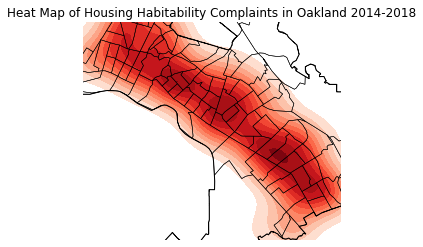

In [22]:
#note: the kernel density heat map helps show three particularly intense areas of complaints

#for future, zoom in on this bounding box of the area we care about which is not a north-south oriented rectangle 
# [-122.1912508998,37.7294442058],[-122.2912073353,37.7971420583],[-122.2585473083,37.8272596933],[-122.1585908729,37.7595894292]


fig, ax = plt.subplots()

gplt.kdeplot(hh_gdf, #dataframe with the point data
             ax=ax,
            shade=True,
            cmap ='Reds')

oakland_bounds.plot(ax=ax,
                   color='None',
                   edgecolors='black',
                   linewidth=1)

tracts_oakland_clipped.plot(ax=ax,
                            color='None',
                            edgecolor='black',
                           linewidth=.5)

ax.set_ylim([37.725, 37.825])
ax.set_xlim([-122.3, -122.15])
[-122.2366988928,37.7466480517],[-122.2895940006,37.8118386842],[-122.2473374041,37.8332448445],[-122.1944422963,37.7680731031]
plt.title('Heat Map of Housing Habitability Complaints in Oakland 2014-2018')
plt.show()

In [23]:
gdf.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'index_right', 'Address', 'HH_Complaint',
       'Address_recode', 'latitude', 'longitude'],
      dtype='object')

In [24]:
# Create Cholopleth Map
#     a) Create data frame of census tracts, their geometry, and the sum of addresses with complaints in that tract
#     b) Run code for basic Choropleth Map
#     c) Save Chloropleth Map to out_maps folder

gdf['unique_complaints'] = 1
#creating the gdf for mapping
hh_tracts = gdf.groupby(['NAME']).sum()
hh_tracts.drop(columns=['ALAND','AWATER','index_right','latitude','longitude'],inplace=True)
hh_tracts.head()

,HH_Complaint,unique_complaints
NAME,,
4001,8,6
4002,3,3
4003,21,13
4004,30,16
4005,7,5


In [25]:
#add in the geometry from the oakland_tracts_clipped version
hh_tracts_gdf = tracts_oakland_clipped.merge(hh_tracts,on='NAME',copy=True)

In [26]:
#this is the dataframe we should use for mapping and analysis of census data
hh_tracts_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 114 entries, 0 to 113
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   STATEFP            114 non-null    object  
 1   COUNTYFP           114 non-null    object  
 2   TRACTCE            114 non-null    object  
 3   AFFGEOID           114 non-null    object  
 4   GEOID              114 non-null    object  
 5   NAME               114 non-null    object  
 6   LSAD               114 non-null    object  
 7   ALAND              114 non-null    int64   
 8   AWATER             114 non-null    int64   
 9   geometry           114 non-null    geometry
 10  HH_Complaint       114 non-null    int64   
 11  unique_complaints  114 non-null    int64   
dtypes: geometry(1), int64(4), object(7)
memory usage: 11.6+ KB


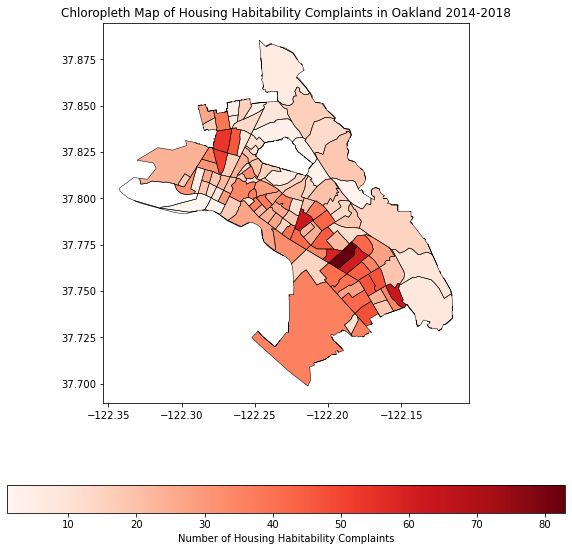

In [27]:
#cholorpleth map of complaints
fig, ax = plt.subplots(figsize = (10,10)) 
hh_tracts_gdf.plot(column='unique_complaints',
                    cmap='Reds',
                    legend=True,
                    legend_kwds={'label': "Number of Housing Habitability Complaints",
                                 'orientation': "horizontal"},
                    ax=ax)

tracts_oakland_clipped.plot(ax=ax,
                            color='None',
                            edgecolor='black',
                           linewidth=.5)

plt.title('Chloropleth Map of Housing Habitability Complaints in Oakland 2014-2018')
plt.show()

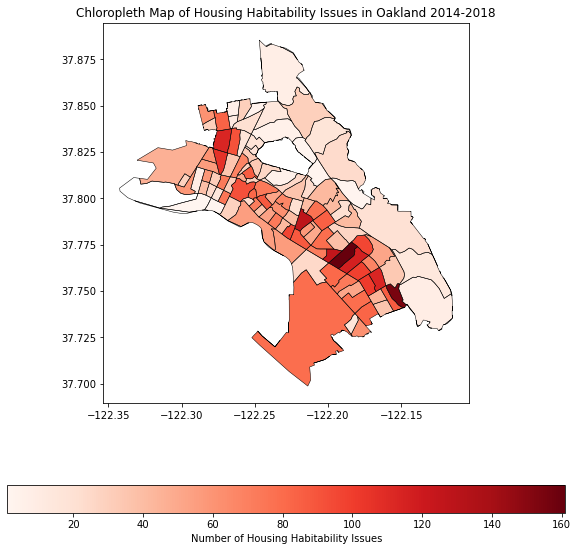

In [28]:
#cholorpleth map of housing habitability 'hits'

fig, ax = plt.subplots(figsize = (10,10)) 
hh_tracts_gdf.plot(column='HH_Complaint',
                    cmap='Reds',
                    legend=True,
                    legend_kwds={'label': "Number of Housing Habitability Issues",
                                 'orientation': "horizontal"},
                    ax=ax)

tracts_oakland_clipped.plot(ax=ax,
                            color='None',
                            edgecolor='black',
                           linewidth=.5)

plt.title('Chloropleth Map of Housing Habitability Issues in Oakland 2014-2018')
plt.show()
#very similar issue

In [29]:
#wondering what the relationship is between the issues and complaints, checking the pearson
np.corrcoef(hh_tracts_gdf['HH_Complaint'],hh_tracts_gdf['unique_complaints'])
#answer is so highly correlated it doesn't really matter which one you use.

array([[1.        , 0.97229046],
       [0.97229046, 1.        ]])

In [30]:
#bringing in the Oakland police beats which are the closest thing we have to neighborhood descriptors
# and are well understood by Oakland policy makers
police_beats = gpd.read_file(rf'C:\Users\amarq\Python_Projects\raw_data\City of Oakland Community Police Beats.geojson')

In [31]:
#changing the crs to be correct
police_beats.to_crs(hh_gdf.crs, inplace=True)

In [32]:
#creating same dataframe across police beats to show 'neighborhoods' better
#spatial join the point data with the police beat data
gpd.sjoin(hh_gdf, police_beats).reset_index(drop=True)

#note, something confusing is happening here. Why all the sudden does it have 5548 rows instead of the original 2776?

,Address,HH_Complaint,Address_recode,latitude,longitude,geometry,index_right,acres,name,shape_area,...,id,pol_beat,fullname,flag,ruleid_1,message,sourcethm,action,pol_sect,shape_len
0,"666 53RD ST, Oakland CA 94609",1,"666 53RD ST, Oakland, CA 94609",37.838473,-122.266529,POINT (-122.26653 37.83847),78,302.82,11X,13413775.911,...,39,11,,0,0,0,Pb,P,1,16480.5905003
1,"675 56TH ST, Oakland CA 94609",1,"675 56TH ST, Oakland, CA 94609",37.840924,-122.266648,POINT (-122.26665 37.84092),78,302.82,11X,13413775.911,...,39,11,,0,0,0,Pb,P,1,16480.5905003
2,"646 AILEEN ST, Oakland CA 94609",1,"646 AILEEN ST, Oakland, CA 94609",37.841939,-122.266132,POINT (-122.26613 37.84194),78,302.82,11X,13413775.911,...,39,11,,0,0,0,Pb,P,1,16480.5905003
3,"629 58TH ST, Oakland CA 94609",2,"629 58TH ST, Oakland, CA 94609",37.843374,-122.266026,POINT (-122.26603 37.84337),78,302.82,11X,13413775.911,...,39,11,,0,0,0,Pb,P,1,16480.5905003
4,"575 58TH ST, Oakland CA 94609",2,"575 58TH ST, Oakland, CA 94609",37.843520,-122.264008,POINT (-122.26401 37.84352),78,302.82,11X,13413775.911,...,39,11,,0,0,0,Pb,P,1,16480.5905003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5543,"5410 WADEAN PL, Oakland CA 94601",1,"5410 WADEAN PL, Oakland, CA 94601",37.770198,-122.203295,POINT (-122.20330 37.77020),42,333.419,27Y,14523640.148,...,4,27,,0,0,0,Pb,P,3,18460.1541151
5544,"4636 INTERNATIONAL BLVD, Oakland CA 94601",2,"4636 INTERNATIONAL BLVD, Oakland, CA 94601",37.770628,-122.210896,POINT (-122.21090 37.77063),42,333.419,27Y,14523640.148,...,4,27,,0,0,0,Pb,P,3,18460.1541151
5545,"1507 48TH AVE, Oakland CA 94601",1,"1507 48TH AVE, Oakland, CA 94601",37.770975,-122.209115,POINT (-122.20912 37.77098),42,333.419,27Y,14523640.148,...,4,27,,0,0,0,Pb,P,3,18460.1541151
5546,"1519 48TH AVE, Oakland CA 94601",1,"1519 48TH AVE, Oakland, CA 94601",37.771069,-122.209045,POINT (-122.20904 37.77107),42,333.419,27Y,14523640.148,...,4,27,,0,0,0,Pb,P,3,18460.1541151


In [33]:
hh_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Address         2776 non-null   object  
 1   HH_Complaint    2776 non-null   int64   
 2   Address_recode  2776 non-null   object  
 3   latitude        2776 non-null   float64 
 4   longitude       2776 non-null   float64 
 5   geometry        2776 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 130.2+ KB


# Importing and Readying ACS Variables

- download csv files of tables for building age, race, tenure, occupants per room for census tracts in Oakland
- clean/prepare variables and merge into single dataframe

## Building Age Dataframe

In [34]:
#bring in table B25306
acs1_df = pd.read_csv(r'C:\Users\amarq\Python_Projects\raw_data\Alameda County Tenure by Year Structure Built_ACS 5 Year 2018.csv')

In [35]:
acs1_df.columns

Index(['id', 'Geographic Area Name', 'Estimate!!Total',
       'Margin of Error!!Total', 'Estimate!!Total!!Owner occupied',
       'Margin of Error!!Total!!Owner occupied',
       'Estimate!!Total!!Owner occupied!!Built 2014 or later',
       'Margin of Error!!Total!!Owner occupied!!Built 2014 or later',
       'Estimate!!Total!!Owner occupied!!Built 2010 to 2013',
       'Margin of Error!!Total!!Owner occupied!!Built 2010 to 2013',
       'Estimate!!Total!!Owner occupied!!Built 2000 to 2009',
       'Margin of Error!!Total!!Owner occupied!!Built 2000 to 2009',
       'Estimate!!Total!!Owner occupied!!Built 1990 to 1999',
       'Margin of Error!!Total!!Owner occupied!!Built 1990 to 1999',
       'Estimate!!Total!!Owner occupied!!Built 1980 to 1989',
       'Margin of Error!!Total!!Owner occupied!!Built 1980 to 1989',
       'Estimate!!Total!!Owner occupied!!Built 1970 to 1979',
       'Margin of Error!!Total!!Owner occupied!!Built 1970 to 1979',
       'Estimate!!Total!!Owner occupied

In [36]:
#rename the columns that we need with c_built_*years*
renamings1 = {'Estimate!!Total': 'c_households',
            'Estimate!!Total!!Owner occupied': 'c_owner_households',
            'Estimate!!Total!!Renter occupied':'c_renter_households',
             'Margin of Error!!Total':'moe_households'}

acs1_df.rename(columns = renamings1, inplace=True)
# def rename_column(column):
# """ pass the name of a column through this function and it renames it in acs1_df
#     using the c_'some name' convention"""
#     if 'renter' in column:
#         return print(column 'not renamed')
#     elif 'Margin of Error' in column:
#         return print(column 'not renamed')
#     else:
#         acs1_df.rename(columns= {columns}
# years = [2014, 2010, 2000, 1990, 1980, 1970, 1960, 1950, 1940, 1939]
# renamings2 = {}
# for year in years:
#     for i in acs1_df.columns:
#         acs1_df[]

In [37]:
acs1_df.columns[6].rsplit('!!',1)[1]

'Built 2014 or later'

In [38]:
#renaming the columns with all the stuff in them so it's a litle more readable
# initialize a dictionary where the keys are the column names and the values are a prettier verison, just for renters
renamings2 = {}
for i in acs1_df.columns:
    if 'Renter' in i:
        if 'Margin' in i:
            renamings2[i] = 'moe_renter_' + i.rsplit('!!',1)[1]
        else:
            renamings2[i] = 'c_renter_' + i.rsplit('!!',1)[1]


In [39]:
#use this dictionary to rename the columns to a more readable fashion
acs1_df.rename(columns= renamings2,inplace=True)

In [40]:
#drop all the columns we don't need
#first use list comprehension to create a list of column names we don't want
c_todrop = [i for i in acs1_df.columns if 'Owner' in i]

In [41]:
acs1_df.drop(columns=c_todrop,inplace=True)

In [42]:
#this is the building ages for renters for each census tract in Alameda County
acs1_df.columns

Index(['id', 'Geographic Area Name', 'c_households', 'moe_households',
       'c_owner_households', 'c_renter_households',
       'moe_renter_Renter occupied', 'c_renter_Built 2014 or later',
       'moe_renter_Built 2014 or later', 'c_renter_Built 2010 to 2013',
       'moe_renter_Built 2010 to 2013', 'c_renter_Built 2000 to 2009',
       'moe_renter_Built 2000 to 2009', 'c_renter_Built 1990 to 1999',
       'moe_renter_Built 1990 to 1999', 'c_renter_Built 1980 to 1989',
       'moe_renter_Built 1980 to 1989', 'c_renter_Built 1970 to 1979',
       'moe_renter_Built 1970 to 1979', 'c_renter_Built 1960 to 1969',
       'moe_renter_Built 1960 to 1969', 'c_renter_Built 1950 to 1959',
       'moe_renter_Built 1950 to 1959', 'c_renter_Built 1940 to 1949',
       'moe_renter_Built 1940 to 1949', 'c_renter_Built 1939 or earlier',
       'moe_renter_Built 1939 or earlier'],
      dtype='object')

In [43]:
acs1_df['p_renter_pre1939'] = acs1_df['c_renter_Built 1939 or earlier'] /  acs1_df['c_renter_households'] 

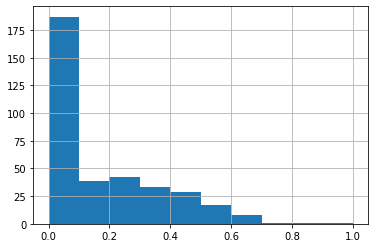

In [44]:
acs1_df['p_renter_pre1939'].hist()

In [55]:
#we merge the tracts_gdf with our ACS data using an attribute join with id in acs1_df and AFFGEOID in tracts_gdf
# first rename id to AFFGEOID in acs1_df

acs1_df.rename(columns={'id':'AFFGEOID'},inplace=True)
acs_gdf = tracts_gdf.merge(acs1_df, on='AFFGEOID')

In [59]:
#TODO - figure out the spatial interpolation bit

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 360 entries, 0 to 359
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   STATEFP                           360 non-null    object  
 1   COUNTYFP                          360 non-null    object  
 2   TRACTCE                           360 non-null    object  
 3   AFFGEOID                          360 non-null    object  
 4   GEOID                             360 non-null    object  
 5   NAME                              360 non-null    object  
 6   LSAD                              360 non-null    object  
 7   ALAND                             360 non-null    int64   
 8   AWATER                            360 non-null    int64   
 9   geometry                          360 non-null    geometry
 10  Geographic Area Name              360 non-null    object  
 11  c_households                      360 non-null    